# CIFAR-10 experiment 1 (09022018)

The goal of this notebook is to explore CIFAR-10 dataset, estabilish an knn benchmark, extract features using a pre-trained ConvNet and fit and evaluate a final SVM classifier.

In [2]:
USING_COLABORATORY = True  # https://colab.research.google.com/
if USING_COLABORATORY:
    try:
        import torch
        print('torch version:', torch.__version__)
    except ImportError:  # In case I'm assigned with a new VM instance
        from os import path
        from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
        platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
        accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
        !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl
        !pip install torchvision numpy sklearn tqdm scipy
        !apt-get install python3-pil -y
        !pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 51kB 1.7MB/s 
    100% |████████████████████████████████| 61kB 4.2MB/s 
    100% |████████████████████████████████| 5.9MB 228kB/s 
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /content/.cache/pip/wheels/d7/db/a3/1b8041ab0be63b5c96c503df8e757cf205c2848cf9ef55f85e
Successfully built sklearn
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libjbig0 liblcms2-2 libtiff5 libwebp6 libwebpmux3 python3-olefile
Suggested packages:
  liblcms2-utils python-pil-doc python3-pil-dbg
The following NEW packages will be installed:
  libjbig0 liblcms2-2 libtiff5 libwebp6 libwebpmux3 python3-olefile
  python3-pil
0 upgraded, 7 newly installed, 0 to remove and 1 not upgraded.
Need to get 862 kB of archives.
After thi

In [29]:
import os
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision.datasets import CIFAR10
from torchvision.transforms import ToPILImage, ToTensor, Compose, Pad, Resize, Lambda, Normalize
from torchvision.utils import make_grid
from torchvision.models import inception_v3, resnet152, vgg19

ROOT_DIR = '.'
FEATURES_DIR = os.path.join(ROOT_DIR, 'features/')
!mkdir -p features
CUDA = USING_COLABORATORY

## CIFAR-10 exploration

First, let us download the dataset and make an additional split of test subset into validation and proper test subsets. Proper test subset will be held out during hyperparameter search, so we could have an unbiased estimate of the accuracy of our final model.

In [30]:
cifar_train = CIFAR10(root=ROOT_DIR, download=True, train=True)
cifar_val = CIFAR10(root=ROOT_DIR, download=True, train=False)
cifar_test = CIFAR10(root=ROOT_DIR, download=True, train=False)
print(len(cifar_train), len(cifar_test))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [31]:
if not CUDA:
    cifar_train.train_data = cifar_train.train_data[:5000]
    cifar_train.train_labels = cifar_train.train_labels[:5000]

splitting_point = int(len(cifar_test)*0.5)
cifar_val.test_data = cifar_val.test_data[:splitting_point]
cifar_val.test_labels = cifar_val.test_labels[:splitting_point]
cifar_test.test_data = cifar_test.test_data[splitting_point:]
cifar_test.test_labels = cifar_test.test_labels[splitting_point:]
print(len(cifar_train), len(cifar_val), len(cifar_test))

5000 5000 5000


Then, let us visualize a random sample from each of ten classes of CIFAR-10 dataset. The classes included are: an airplane, an automobile, a bird, a deer, a dog, a frog, a horse, a ship, and a truck.

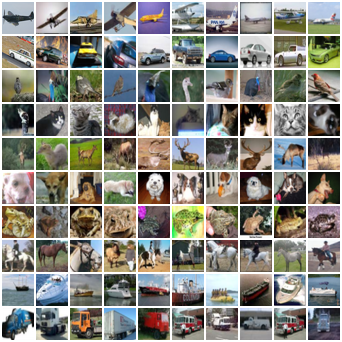

In [32]:
show = ToPILImage()
tensorize = ToTensor()

def sample(dataset_labels, class_num, sample_size=10):
    return np.random.choice(
        np.where(np.array(dataset_labels) == class_num)[0], 
        size=sample_size
    )

grid = make_grid([
    tensorize(cifar_train.train_data[idx])
    for class_num in range(10)
    for idx in sample(cifar_train.train_labels, class_num)
], pad_value=1, nrow=10)
show(grid)

# kNN baseline

Now let us estabilish a baseline. We will train a *k* nearest neighbours classifier with $k=5$. We will use no feature engineering.

In [7]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')
knn.fit(
    cifar_train.train_data.reshape(-1, 32*32*3)[:5000], 
    cifar_train.train_labels[:5000]
)
knn.score(
    cifar_val.test_data.reshape(-1, 32*32*3),
    cifar_val.test_labels
)

0.2672

This is significantly better than random guessing.

# Extracting image features using a pre-trained CNN

We will extract features using for downstream classification using [Inception-v3](http://arxiv.org/abs/1512.00567) network pretrained on ImageNet dataset.

In [8]:
inception_model = inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /content/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:04<00:00, 23809487.38it/s]


In [9]:
inception_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d (3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d (64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d (80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (Mixed_5b): InceptionA(
    (branch1x1): BasicConv2d(
      (conv): Conv2d (192, 64, kernel_si

## Reimplenenting Inception as feature extractor

There are two major problems with transfering knowledge from ImageNet to CIFAR-10 using Inception-v3 in PyTorch. The first problem is that is is difficult to just slice offthe final fully-connected layer when the computation graph is created on the fly. While in Tensorflow and Keras you can easily fetch a `pool_3` layer by name and set it as your new output layer (by doing `Session.run([pool_3], ...)` or `model.compile(output=pool_3)`, respectively), in PyTorch the computation graph of a pre-trained model is not fully defined prior to execution. In simpler models (build as sequence of modules, with no non-module ops), you could get around this and do
```python
feature_extractor = Sequential(*list(pretrained_cnn.children())[:-1])
```

However, this is not possibe in the case of Inception-v3. What I had to do was to re-implement Inception-v3's `forward` pass (without the final layer) and copy its weight from the `original_inception`.

In [0]:
class InceptionFeatureExtractor(nn.Module):
    
    def __init__(self, original_inception, **kwargs):
        super(InceptionFeatureExtractor, self).__init__(**kwargs)
        for name, module in original_inception.named_children():
            module.requires_grad = False  # Just letting autograd know there'll be no backward pass
            setattr(self, name, module)

        
    def forward(self, x):
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        return x


In [0]:
inception_feature_extractor = InceptionFeatureExtractor(original_inception=inception_model)
assert list(inception_model.named_parameters()) == list(inception_feature_extractor.named_parameters())

In [12]:
sample = Variable(torch.FloatTensor(torch.rand(5, 3, 300, 300)))
inception_feature_extractor(sample)

Variable containing:
 0.3196  0.2101  0.3621  ...   0.5235  0.2090  0.2755
 0.3780  0.2471  0.4524  ...   0.5615  0.2385  0.3489
 0.3952  0.1174  0.1326  ...   0.4688  0.6911  0.3821
 0.3321  0.6345  0.3329  ...   0.1190  0.3721  0.2734
 0.1751  0.2639  0.1342  ...   0.2939  0.3366  0.4289
[torch.FloatTensor of size 5x2048]

## Resizing CIFAR-10

The second problem is that while the sizes of ImageNet images are around 300x300 px, CIFAR-10 images are tiny (32x32 px). When passing them through Inception-v3, subsequent convolutions and poolings shrink their size so rapidly that eventually some kernel turnes out to be to large to be applied to its input.

There are several ways to get around this problem:
* Tinker with kernel sizes
* Interpolate CIFAR-10 image to around 300x300 px
* Zero-pad CIFAR-10 images to around 300x300 px
* Self-concatenete CIFAR-10 images together until they are around 300x300 px

I rejected the first approach, because I'd probably end up destroying carefully optimized weights. One major worry I had about the second approach was that after interpolation images will be too blurry for Inception to extract features from it. (Consider a 1 px wide edge. After interpolation, It'll be around 10 px wide. However, kernel in Inception-v3 first layer are only 3x3 -- they'll be unable to detect a 10 px wide edge). Finally, I decided to try approaches 2-4.

Sampled transformations: bilinear-interpolation lanczos-interpolation zero-padding self-concatenation


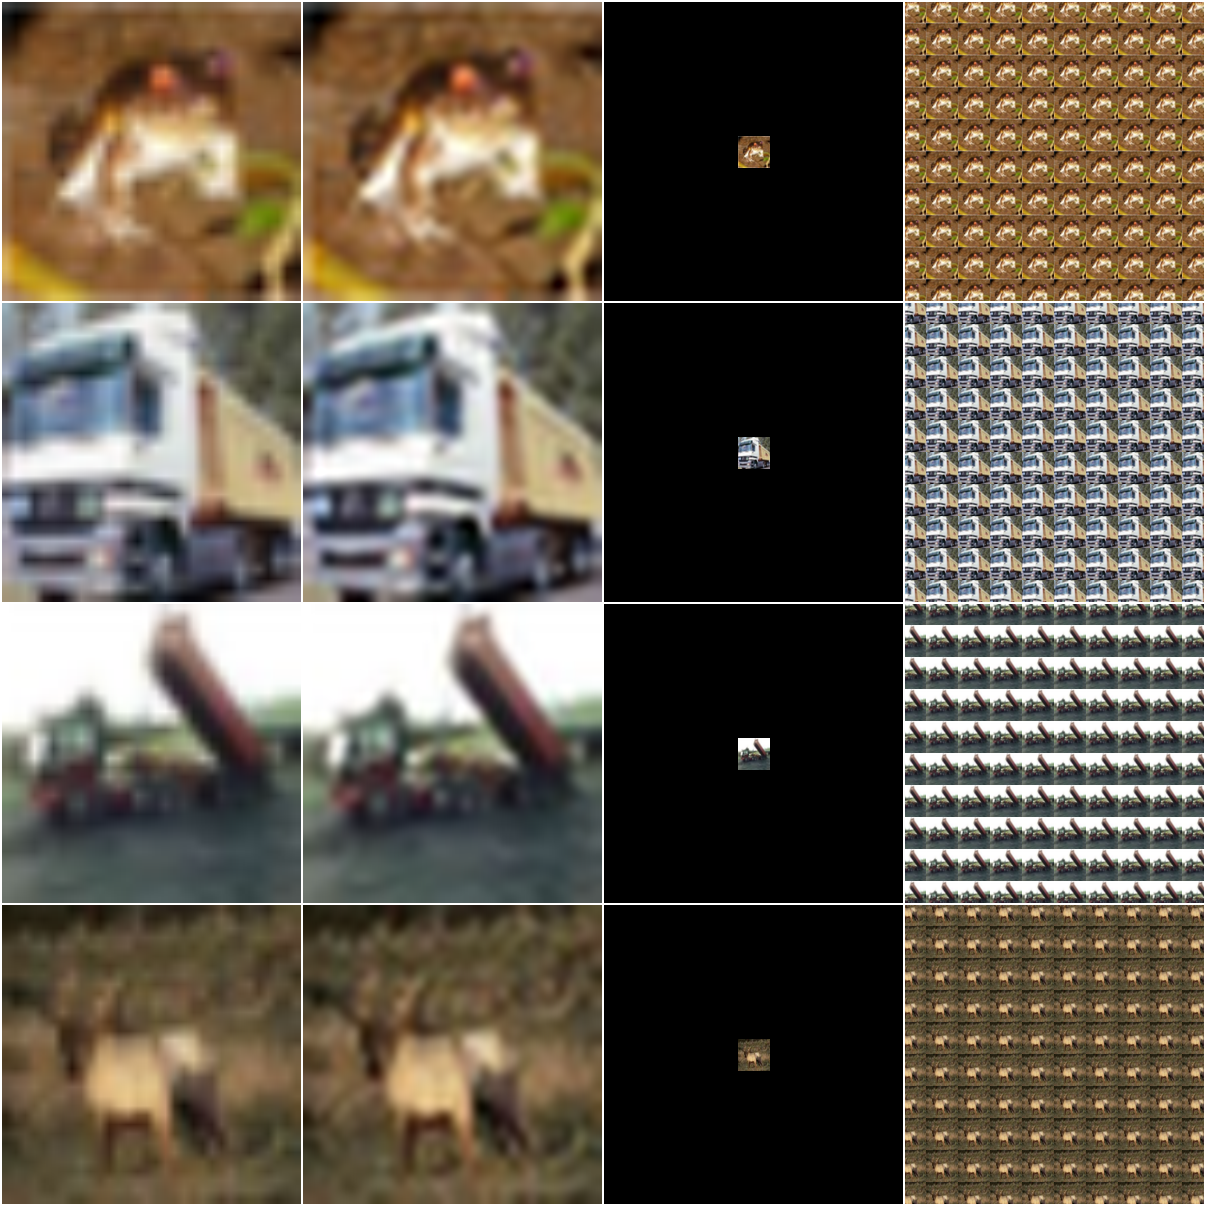

In [33]:
def self_concatenate(arr):
    arr = np.hstack([arr]*10)
    arr = np.vstack([arr]*10)
    return arr[11:-10, 11:-10, :]

transforms = {
    'bilinear-interpolation': Compose([Resize((299, 299), interpolation=2), ToTensor()]),
    'lanczos-interpolation': Compose([Resize((299, 299), interpolation=1), ToTensor()]),
    'zero-padding': Compose([Pad((134, 134, 133, 133)), ToTensor()]),
    'self-concatenation': Compose([Lambda(self_concatenate), ToTensor()]),
}

print('Sampled transformations:', *transforms.keys())
show(make_grid([transform(show(cifar_train.train_data[i])) 
                for i in range(4) for transform in transforms.values()
               ], pad_value=1, nrow=4))

And after normalization

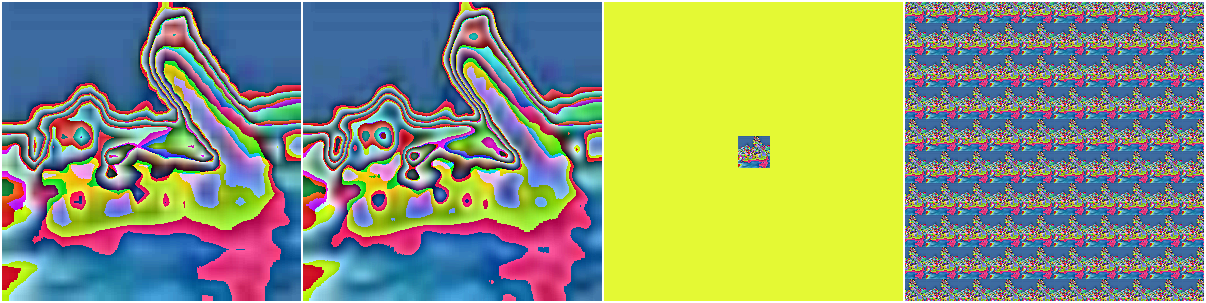

In [34]:
for key, transform in transforms.items():
    transforms[key] = Compose([transform, Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

show(make_grid([transform(show(cifar_train.train_data[2])) for transform in transforms.values()], pad_value=1, nrow=4))

## Forward pass through `InceptionFeatureExtractor`

In [0]:
inception_feature_extractor.eval()
if CUDA:
    inception_feature_extractor = inception_feature_extractor.cuda()
    
def get_loader(dataset, transform):
  dataset.transform = transform
  return DataLoader(dataset, batch_size=64 if CUDA else 8, 
                    shuffle=False, num_workers=0, pin_memory=CUDA)
  
    
def extract_features(extractor, dataloader):
    # Allocate some memory
    features = np.ndarray(shape=(len(dataloader.dataset), 2048))
    for i, (batch, _) in enumerate(dataloader):
        batch = Variable(batch, requires_grad=False, volatile=True)
        if CUDA:
            batch = batch.cuda()
        features_batch = inception_feature_extractor(batch)
        step_size = batch.shape[0]
        features[i*step_size:(i+1)*step_size] = features_batch.data.cpu().numpy()
    return features


In [17]:
for resize_method_name, transform in transforms.items():
    print(resize_method_name)
    features = extract_features(
        inception_feature_extractor, 
        get_loader(cifar_train, transform)
    )
    np.save(FEATURES_DIR + resize_method_name + '_train', features)
    val_features = extract_features(
        inception_feature_extractor, 
        get_loader(cifar_val, transform)
    )
    np.save(FEATURES_DIR + resize_method_name + '_val', val_features)

bilinear-interpolation
lanczos-interpolation
zero-padding
self-concatenation


In [18]:
!ls -lh features/

total 3.4G
-rw-r--r-- 1 root root 782M Feb 13 13:44 bilinear-interpolation_train.npy
-rw-r--r-- 1 root root  79M Feb 13 13:45 bilinear-interpolation_val.npy
-rw-r--r-- 1 root root 782M Feb 13 13:56 lanczos-interpolation_train.npy
-rw-r--r-- 1 root root  79M Feb 13 13:58 lanczos-interpolation_val.npy
-rw-r--r-- 1 root root 782M Feb 13 14:19 self-concatenation_train.npy
-rw-r--r-- 1 root root  79M Feb 13 14:20 self-concatenation_val.npy
-rw-r--r-- 1 root root 782M Feb 13 14:08 zero-padding_train.npy
-rw-r--r-- 1 root root  79M Feb 13 14:09 zero-padding_val.npy


# Visualizing CNN codes

Let us inspect our image embeddings by projecting them onto a 2d space. We will use t-SNE (more specifically, Barnes-Hut approximation of t-SNE), a technique known for preserving local structure of a manifold. Before applying t-SNE, however, we will project our 2048 dimensions onto 60 using plain PCA. This will suppress some noise and speed up the computation. Also, we will limit the number of data points for visualization to 10000. 

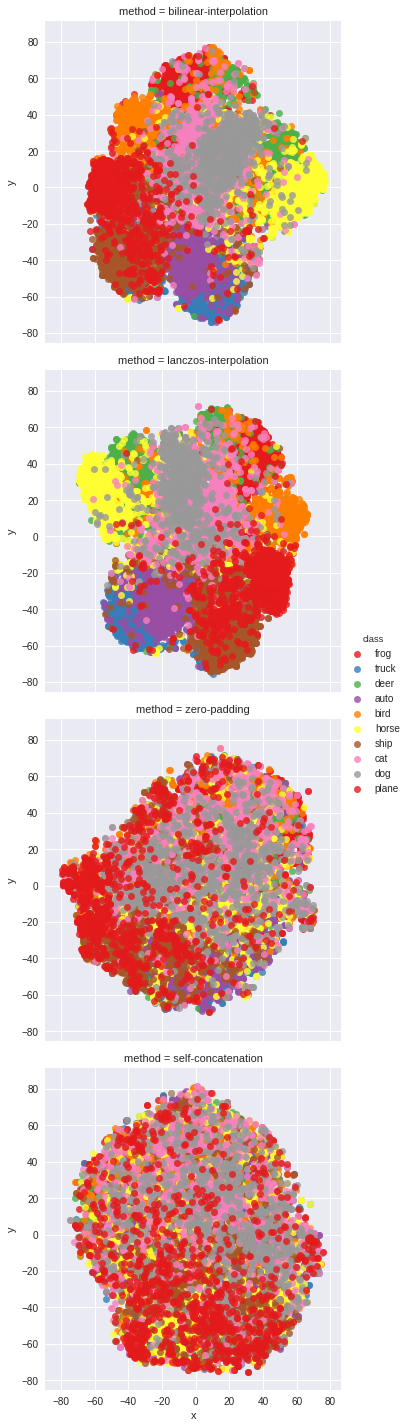

In [19]:
df = pd.DataFrame()
labels = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
classes = list(map(lambda x: labels[x], cifar_train.train_labels[:10000]))

for resize_method_name in transforms:
    features = np.load(FEATURES_DIR + resize_method_name + '_train.npy')[:10000]
    pca50 = PCA(n_components=50)
    features_50d = pca50.fit_transform(features)
    tsne = TSNE(n_components=2)
    features_2d = tsne.fit_transform(features_50d)

    
    
    df = df.append(pd.DataFrame({'x': features_2d[:, 0], 
                                 'y': features_2d[:, 1], 
                                 'class': classes,
                                 'method': [resize_method_name]*len(classes)}))

sns.lmplot(x="x", y="y", hue='class', row='method', data=df, fit_reg=False, legend=True, palette="Set1")

We see a huge qualitatice difference between image embeddings extracted using two first and two last resizing strategies. Interpolations produce much more well-separated clusters of image contents.

# Running a linear SVM classifier on image embeddings

In [0]:
trained_classifiers = {}
results = pd.DataFrame(columns=['transform', 'c', 'accuracy'])
for resize_method_name in transforms:
    features = np.load(FEATURES_DIR + resize_method_name + '_train.npy')
    val_features = np.load(FEATURES_DIR + resize_method_name + '_val.npy')
    val_features[val_features != val_features] = 0  # Remove NaNs
    for c in [0.001, 0.005, 0.01, 0.1, 1, 10]:
        clf = LinearSVC(verbose=1, C=c, dual=False, max_iter=100000)
        clf.fit(features, cifar_train.train_labels)
        score = clf.score(val_features, cifar_val.test_labels)
        print(resize_method_name, c, score)
        trained_classifiers[resize_method_name+str(c)] = clf
        results.loc[len(results)] = [resize_method_name, c, score]

[LibLinear]bilinear-interpolation 0.001 0.8388
[LibLinear]bilinear-interpolation 0.005 0.8442
[LibLinear]bilinear-interpolation 0.01 0.843
[LibLinear]bilinear-interpolation 0.1 0.8356
[LibLinear]bilinear-interpolation 1 0.8204
[LibLinear]bilinear-interpolation 10 0.809
[LibLinear]lanczos-interpolation 0.001 0.8532
[LibLinear]lanczos-interpolation 0.005 0.8584
[LibLinear]lanczos-interpolation 0.01 0.8578
[LibLinear]lanczos-interpolation 0.1 0.8438
[LibLinear]lanczos-interpolation 1 0.8296
[LibLinear]lanczos-interpolation 10 0.8172
[LibLinear]zero-padding 0.001 0.5834
[LibLinear]zero-padding 0.005 0.6174
[LibLinear]zero-padding 0.01 0.6296
[LibLinear]zero-padding 0.1 0.6438
[LibLinear]zero-padding 1 0.6392
[LibLinear]

In [21]:
results

,transform,c,accuracy
0,bilinear-interpolation,0.001,0.8388
1,bilinear-interpolation,0.005,0.8442
2,bilinear-interpolation,0.010,0.8430
3,bilinear-interpolation,0.100,0.8356
4,bilinear-interpolation,1.000,0.8204
5,bilinear-interpolation,10.000,0.8090
6,lanczos-interpolation,0.001,0.8532
7,lanczos-interpolation,0.005,0.8584
8,lanczos-interpolation,0.010,0.8578
9,lanczos-interpolation,0.100,0.8438


In [57]:
final_method = 'lanczos-interpolation'
final_c = 0.005
clf = trained_classifiers[final_method + str(final_c)]
joblib.dump(clf, final_method + str(final_c) + '.pkl')

['lanczos-interpolation0.005.pkl']

It turned out that simple interpolation method beats my resizing strategies by a huge marigin. What this shows is that I'm pretty ignorant when it comes to computer vision.

# Error analysis

In [0]:
def show_confusion_matrix(method, c):
    clf = trained_classifiers[method + str(c)]
    val_features = np.load(FEATURES_DIR + method + '_val.npy')
    predictions = clf.predict(val_features)
    confusions = confusion_matrix(predictions, cifar_val.test_labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusions, square=True, xticklabels=labels, 
                     yticklabels=labels, annot=True, linewidths=.5, ax=ax, fmt='d')
    ax.set_title(f'Method = {method}, c = {c}')

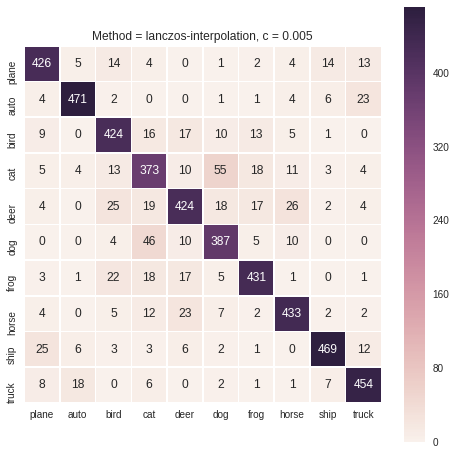

In [30]:
show_confusion_matrix('lanczos-interpolation', 0.005)

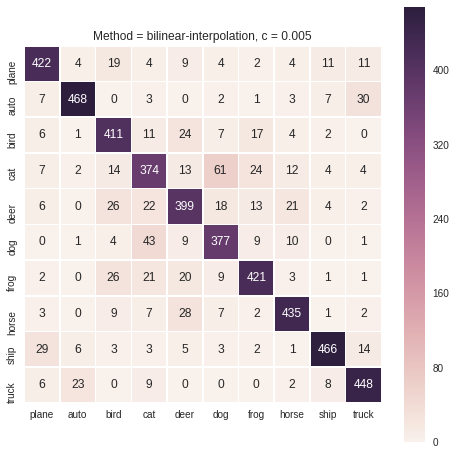

In [40]:
show_confusion_matrix('bilinear-interpolation', 0.005)

All highest scoring models show similar error patterns: there is a (pretty symmetric) cat vs. dog issue. Minor issues include plane vs. ship and car vs. truck.

# Final evaluation

Finally, let us evaluated our final model one more time on a previously untouched test set.

In [0]:
torch.cuda.empty_cache()  # GPU sometimes runs out of memory at this point

In [62]:
final_method = 'lanczos-interpolation'
final_c = 0.005
clf = joblib.load(final_method + str(final_c) + '.pkl') 

test_features = extract_features(inception_feature_extractor, 
                                 get_loader(cifar_test, transforms[final_method]))
score = clf.score(test_features, cifar_test.test_labels)
print(score)

0.8636


And here we are are! We could've expected a little higher accuracy (at least 0.87, they say), but at least we're not overfitting our hyperparams to validation set. I haven't found any bugs in my code that could account for this accuracy drop (and I searched for them!). Possible reasons are slight differences in implementation of some convolutions/batchnorm ops between PyTorch and Tensorflow or numerical inaccuracies when porting the pretrained Inception-v3 model from Tensorflow over to PyTorch. (The model I downloaded was originally trained by Google folks using Tensorflow.)